# tensor pre-requisites

original: https://github.com/peluche/pre-arena

## setup

In [1]:
%pip install -qU gensim

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import torch as t
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import gensim.downloader
from sklearn.decomposition import PCA

%matplotlib inline

In [3]:
t.manual_seed(0xdeadbeef)

class CFG:
    schools = 5
    classes = 3
    students = 20
    exams = 10

data = t.randint(0, 100, (CFG.schools, CFG.classes, CFG.students, CFG.exams))

In [4]:
def draw(frames, figsize=(6, 6), display_inline=True, filename=None):
  def get_frame(ax):
    def f(d):
      ax.clear()
      ax.axis('off')
      ax.margins(0)
      ax.imshow(frames[d], cmap='binary')
    return f

  fig, ax = plt.subplots(figsize=figsize)
  fig.tight_layout()
  ani = FuncAnimation(fig, get_frame(ax), frames=len(frames), interval=50, repeat=False)
  plt.close()
  if display_inline: display(HTML(ani.to_jshtml())) # display inline
  if filename is not None: ani.save(filename, fps=20) # save to disk

In [5]:
t.manual_seed(0xdeadbeef)
x = t.randn(20).view(-1, 2)
normalized_x = (x - x.mean(0, keepdim=True))
colors = t.arange(len(normalized_x))

def get_best_angle(normalized_x):
    # /!\ this is for demo purpose only
    mini = float('inf')
    best_angle = 0
    # iterate over all (~not really but shush~)
    for i in range(0, 180):
        sum_of_squared_distances = 0
        angle = math.radians(i)
        slope = t.tensor([math.cos(angle), math.sin(angle)])
        for point in normalized_x:
            projection = (point.dot(slope) / slope.dot(slope)) * slope
            squared_distance = (point - projection).pow(2).sum()
            sum_of_squared_distances += squared_distance
        if sum_of_squared_distances < mini:
            mini = sum_of_squared_distances
            best_angle = i
    return best_angle

def plot_line(plt, angle):
    ar = math.radians(angle)
    v = t.tensor([math.cos(ar), math.sin(ar)])
    x_min, x_max, y_min, y_max = plt.axis()
    diag = t.tensor([x_max - x_min, y_max - y_min]).norm()
    v *= diag / 2.
    plt.plot([-v[0], v[0]], [-v[1], v[1]], linestyle='--', color='red', label=f'Angle: {angle}°')

def rotate(data, angle):
    angle = math.radians(angle)
    rotation_matrix = t.tensor([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
    rotated = t.zeros_like(data)
    for i, point in enumerate(data):
        rotated[i] = rotation_matrix.T @ point
    return rotated

def plot_step(ax, data, angle):
    ax.scatter(data[:, 0], data[:, 1], c=colors, cmap='viridis')
    plot_line(ax, angle)

def get_scale(data, angle, delta=0.1):
    xs = [*data[:, 0].tolist()]
    ys = [*data[:, 1].tolist()]
    for i in range(angle + 1):
        rotated = rotate(data, angle)
        xs.extend(rotated[:, 0].tolist())
        ys.extend(rotated[:, 1].tolist())
    return min(xs) - delta, max(xs) + delta, min(ys) - delta, max(ys) + delta

def get_frame(ax, data, angle):
    min_x, max_x, min_y, max_y = get_scale(data, angle)    
    def f(step):
        ax.clear()
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)
        rotated = rotate(data, step)
        plot_step(ax, rotated, angle - step)
    return f

def animate_pca(data, angle, figsize=(5, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ani = FuncAnimation(fig, get_frame(ax, data, angle), frames=angle + 1, interval=50, repeat=False)
    plt.close()
    return ani

def pca_basis_change():
    best_angle = get_best_angle(normalized_x)
    ani = animate_pca(normalized_x, best_angle)
    display(HTML(ani.to_jshtml())) # display in notebook
    # ani.save('imgs/pca_rotation.gif', fps=20) # save to disk

def plot_step_collapse(ax, data, scale):
    ax.scatter(data[:, 0], data[:, 1] * scale, c=colors, cmap='viridis')
    plot_line(ax, 0)

def get_frame_collapse(ax, data, steps):
    min_x, max_x, min_y, max_y = get_scale(data, 0)
    def f(step):
        ax.clear()
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)
        plot_step_collapse(ax, data, (steps - step) / steps)
    return f

def animate_pca_collapse(data, figsize=(5, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    steps = 30
    ani = FuncAnimation(fig, get_frame_collapse(ax, data, steps), frames=steps + 1, interval=50, repeat=False)
    plt.close()
    return ani

def pca_collapse():
    best_angle = get_best_angle(normalized_x)
    rotated = rotate(normalized_x, best_angle)
    ani = animate_pca_collapse(rotated)
    display(HTML(ani.to_jshtml())) # display in notebook

### answers /!\ SPOILER INSIDE /!\

#### tensor manipulation

In [6]:
# find the highest score in the district
def _district_highest_score(data):
    return data.max()
def test_district_highest_score(x):
    assert x.allclose(_district_highest_score(data))

# find the best score for each exam in each class in each school
def _best_score_per_exam(data):
    return data.max(dim=2).values
def test_best_score_per_exam(x):
    assert x.allclose(_best_score_per_exam(data))

# what class has the best average score in each school
def _best_class(data):
    return data.mean(dim=(2, 3), dtype=t.float32).argmax(dim=1)
def test_best_class(x):
    assert x.allclose(_best_class(data))

# compute how many exams each student has failed (score < 50)
def _failed_exams(data):
    return (data < 50).sum(dim=3)
def test_failed_exams(x):
    assert x.allclose(_failed_exams(data))

# what was the hardest exam accross the district
def _hardest_exam(data):
    return data.sum(dim=(0, 1, 2)).argmin()
def test_hardest_exam(x):
    assert x.allclose(_hardest_exam(data))

# how many students will graduate (GPA >= 50)
def _how_many_graduate(data):
    return (data.float().mean(dim=3) > 50).sum()
def test_how_many_graduate(x):
    assert x.allclose(_how_many_graduate(data))

# how many more students will graduate if the hardest exam is removed
def _how_many_graduate_without_hardest_exam(data):
    copy = data.clone()
    copy[:, :, :, _hardest_exam(data)] = 50
    return _how_many_graduate(copy) - _how_many_graduate(data)
def _how_many_graduate_without_hardest_exam2(data):
    hardest_exam = _hardest_exam(data)
    data_without_hardest_exam = t.cat((data[..., 0:hardest_exam], data[..., hardest_exam+1:]), dim=3)
    return _how_many_graduate(data_without_hardest_exam) - _how_many_graduate(data)
def test_how_many_graduate_without_hardest_exam(x):
    assert x.allclose(_how_many_graduate_without_hardest_exam(data))
    assert x.allclose(_how_many_graduate_without_hardest_exam2(data))

# what score did the worst student (lowest GPA) got on the their best exam
def _worst_student_best_exam(data):
    lowest_gpa = data.sum(dim=3).min()
    idx = data.sum(dim=3) == lowest_gpa
    return data[idx].max()
def test_worst_student_best_exam(x):
    assert x.allclose(_worst_student_best_exam(data))

#### game of life

In [7]:
def _count_neighbors(world):
    kernel = t.ones(1, 1, 3, 3)
    kernel[0, 0, 1, 1] = 0
    return F.conv2d(world[None, None], kernel, padding=1)[0, 0]

def test_count_neighbors(f, world):
    assert f(world).allclose(_count_neighbors(world))

def _next_step(world):
    neighbors = _count_neighbors(world)
    next_generation = (neighbors == 3) | ((world == 1) & (neighbors == 2))
    return next_generation.float()

def test_next_step(f, world):
    assert f(world).allclose(_next_step(world))

#### embeddings / word2vec / PCA

In [8]:
# compute the similarity between two words using cosine similarity https://en.wikipedia.org/wiki/Cosine_similarity
def _cosine_similarity(word1, word2, word2vec):
    # <STUDENT JOB>
    e1 = t.tensor(word2vec[word1])
    e2 = t.tensor(word2vec[word2])
    return t.dot(e1, e2) / (t.norm(e1) * t.norm(e2))
def test_cosine_similarity(f, word1, word2, word2vec):
    assert f(word1, word2).allclose(_cosine_similarity(word1, word2, word2vec))

# create a 2d tensor of shape [words, embedding_size]
def _words_to_embeddings(words, word2vec):
    embeddings = [t.tensor(word2vec[word]) for word in words]
    return t.stack(embeddings)
def test_words_to_embeddings(f, words, word2vec):
    assert f(words).allclose(_words_to_embeddings(words, word2vec))

## tensor manipulation

We will be working with a 4d tensor `data` representing each schools in a district of shape `[school, class, student, exam]`

For example:
`data[0, 5, 2, 1]`

would tell us what score the 3rd student in the 6th class of the first school scored on their second exam

In [9]:
# find the highest score in the district
# <STUDENT JOB>
answer = data.max()

test_district_highest_score(answer)

In [10]:
# find the best score for each exam in each class in each school
# <STUDENT JOB>
answer = data.max(dim=2).values

test_best_score_per_exam(answer)

In [11]:
# what class has the best average score in each school
# <STUDENT JOB>
answer = data.mean(dim=(2, 3), dtype=t.float32).argmax(dim=1)

test_best_class(answer)

In [12]:
# compute how many exams each student has failed (score < 50)
# <STUDENT JOB>
answer = (data < 50).sum(dim=3)

test_failed_exams(answer)

In [13]:
# what was the hardest exam accross the district
# <STUDENT JOB>
answer = data.sum(dim=(0, 1, 2)).argmin()

test_hardest_exam(answer)

In [14]:
# how many students will graduate (GPA >= 50)
# <STUDENT JOB>
answer = (data.float().mean(dim=3) > 50).sum()

test_how_many_graduate(answer)

In [15]:
# how many more students will graduate if the hardest exam is removed
# <STUDENT JOB>
copy = data.clone()
copy[:, :, :, _hardest_exam(data)] = 50
answer = _how_many_graduate(copy) - _how_many_graduate(data)

hardest_exam = _hardest_exam(data)
other = t.cat((data[..., 0:hardest_exam], data[..., hardest_exam+1:]), dim=3)
answer = _how_many_graduate(other) - _how_many_graduate(data)

test_how_many_graduate_without_hardest_exam(answer)

In [16]:
# what score did the worst student (lowest GPA) got on their best exam
# <STUDENT JOB>
lowest_gpa = data.sum(dim=3).min()
idx = data.sum(dim=3) == lowest_gpa
idx.shape
answer = data[idx].max()

test_worst_student_best_exam(answer)

## game of life

https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life

we can represent the world as a 2d tensor of shape `[height, width]` where `0.` means dead, and `1.` means alive

In [17]:
world = t.tensor([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]], dtype=t.float32)

world.shape

torch.Size([8, 8])

game of life is a celullar automata obeying the following rules:
- Any live cell with fewer than two live neighbors dies, as if by underpopulation.
- Any live cell with two or three live neighbors lives on to the next generation.
- Any live cell with more than three live neighbors dies, as if by overpopulation.
- Any dead cell with exactly three live neighbors becomes a live cell, as if by reproduction.

In [18]:
# find how many neighbors each cell has
def count_neighbors(world):
    # <STUDENT JOB>
    kernel = t.ones(1, 1, 3, 3)
    kernel[0, 0, 1, 1] = 0
    return F.conv2d(world[None, None], kernel, padding=1)[0, 0]

test_count_neighbors(count_neighbors, world)

Note: boolean operations between tensors have lower priorities so they require parenthesis.

In [19]:
# return a new world for next step according to the rules of game of life
def next_step(world):
    world = world.clone()
    # <STUDENT JOB>
    neighbors = count_neighbors(world)
    next_generation = (neighbors == 3) | ((world == 1) & (neighbors == 2))
    return next_generation.float()

test_next_step(next_step, world)

In [20]:
def play(world, epochs=10):
    frames = [world]
    for _ in range(epochs):
        world = next_step(world)
        frames.append(world.clone())
    draw(frames)

play(world)

## embeddings / word2vec / PCA

Run the cell and go grab a drink 

In [21]:
word2vec = gensim.downloader.load('word2vec-google-news-300') # 1.6 GB

Word2Vec is an embedding table. It associates words to some vector of float numbers. It has been trained by training a network to predict the middle word in sentences from google news.

e.g. "There riots in _____ continue, french people are complaining about retirements" → "Paris"

In [22]:
embedding = t.tensor(word2vec['Paris'])
embedding.shape

torch.Size([300])

In [23]:
# compute the similarity between two words using cosine similarity https://en.wikipedia.org/wiki/Cosine_similarity
def cosine_similarity(word1, word2):
    # <STUDENT JOB>
    e1 = t.tensor(word2vec[word1])
    e2 = t.tensor(word2vec[word2])
    return t.dot(e1, e2) / (t.norm(e1) * t.norm(e2))

test_cosine_similarity(cosine_similarity, 'Paris', 'France', word2vec)

Notice that similar words have bigger cosine similarities.

In [24]:
for word in ['Paris', 'France', 'Germany', 'tomato']:
    print(f'cosine similarity between "Paris" and "{word}": {cosine_similarity("Paris", word):.4f}')

cosine similarity between "Paris" and "Paris": 1.0000
cosine similarity between "Paris" and "France": 0.6335
cosine similarity between "Paris" and "Germany": 0.3408
cosine similarity between "Paris" and "tomato": -0.0004


One fun application is to use these embedding (vector representation of a word) to do word arithmetic

In [25]:
e = word2vec['Paris'] - word2vec['France'] + word2vec['Germany']
word2vec.similar_by_vector(e, topn=1)

[('Berlin', 0.7628204822540283)]

In [26]:
e = word2vec['king'] - word2vec['man'] + word2vec['woman']
word2vec.similar_by_vector(e, topn=3)

[('king', 0.8449392318725586),
 ('queen', 0.7300517559051514),
 ('monarch', 0.645466148853302)]

In [27]:
e = word2vec['Italy'] - word2vec['Rome'] + word2vec['Tokyo']
word2vec.similar_by_vector(e, topn=3)

[('Japan', 0.7775930762290955),
 ('Tokyo', 0.7542712688446045),
 ('Japanese', 0.643976628780365)]

Visualize the embeddings in 2d using PCA https://en.wikipedia.org/wiki/Principal_component_analysis

PCA lets us reduce the dimensionality of the data by changing the basis vector for our vector space and throwing away the basis with the least significances. It's a lossy way to compress a vector into a smaller vector.

First by chosing the line that minimize the distance to all points, and rotating around it.

In [28]:
pca_basis_change()

then collapsing the points into this line (throwing away the `y` axis)

In [29]:
pca_collapse()

we can compute the PCA for a set of vectors using https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [30]:
# create a tensor of shape [words, embedding_size]
def words_to_embeddings(words):
    # <STUDENT JOB>
    embeddings = [t.tensor(word2vec[word]) for word in words]
    return t.stack(embeddings)

words = ['Paris', 'Rome', 'Tokyo', 'tomato', 'banana', 'apple', 'king', 'queen']
test_words_to_embeddings(words_to_embeddings, words, word2vec)

It is hard to visualize embeddings with 300 dimensions, but we can use 2D PCA to visualize the embeddings of the words in 2D and build some intuitions

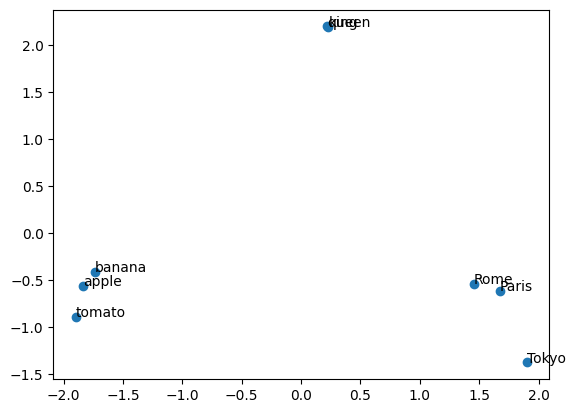

In [31]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(words_to_embeddings(words))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, (principal_components[i, 0], principal_components[i, 1]))
plt.show()